# Coastal Urbanization <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
<!-- [s2_l2a](https://explorer.digitalearth.africa/s2_l2a) -->

## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Africa. 

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Africa helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import subprocess as sp
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datacube.utils.cog import write_cog
import folium.plugins
import folium
from odc.algo import xr_geomedian, int_geomedian
from odc.ui import with_ui_cbk
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_coastaltools import tidal_tag
from deafrica_spatialtools import subpixel_contours, interpolate_2d,  contours_to_arrays
from deafrica_plotting import display_map, rgb
from deafrica_dask import create_local_dask_cluster
import rioxarray
import rasterio
import rasterio.windows as windows
from rasterio.enums import Resampling
from skimage.morphology import disk, dilation

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
#create the dask client
create_local_dask_cluster()


Client Scheduler: tcp://127.0.0.1:44169 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.

In [3]:
lat, lon= 16.01366, -16.49195 #'stlouis'
buffer = 0.1
time_range = ('2000', '2018')
dask_chunks = {'time' : -1, 'x' : 1000, 'y' : 1000}
bands = ['red','green','blue', 'nir', 'swir1', 'swir2']
products=['ls5_usgs_sr_scene', 'ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']
resolution = (-30, 30)

In [ ]:
# display_map((lon-buffer, lon+buffer),(lat-buffer, lat+buffer))

### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [4]:
dc = datacube.Datacube(app='coastal_urbanization')

### Load satellite data

In [5]:
query = {'time': time_range,
         'x':(lon-buffer, lon+buffer),
         'y':(lat-buffer, lat+buffer),
         'products': products,
         'measurements': bands,
         'resolution': resolution,
         'dask_chunks':dask_chunks,
         'output_crs': 'EPSG:6933',
         'group_by':'solar_day'
            }

In [6]:
ds = load_ard(dc=dc, dtype='native', **query)
print(ds)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls5_usgs_sr_scene
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 447 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 447, x: 644, y: 819)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-23T11:19:52.270397 ... 2018-12...
  * y            (y) float64 2.029e+06 2.029e+06 ... 2.005e+06 2.005e+06
  * x            (x) float64 -1.601e+06 -1.601e+06 ... -1.582e+06 -1.582e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) int16 dask.array<chunksize=(447, 819, 644), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(447, 819, 644), meta=np.ndarray>
    blue         (time, y, x) int16 dask.array<chunksize=(447, 819, 644), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(447, 819, 644), meta=np.ndarray>
    swir1        (time, y, x) int16 dask.array<chunksize=(447, 819, 644), m

## Model tide heights for each observation

We use the `tidal_tag` function from `deafrica_coastaltools` to associate each satellite observation in our timeseries with a tide height relative to mean sea level. This function uses the time and date of acquisition and the geographic location of each satellite observation as inputs to the OSU Tidal Prediction Software (OTPS) tidal model. 

In [ ]:
# tide_range = (0.75, 1.00)

In [ ]:
# ds = tidal_tag(ds)

# # Print output data
# print(ds)

In [ ]:
# Calculate the min and max tide heights to include based on the % range
# min_tide, max_tide = landsat_ds.tide_height.quantile(tide_range) 

# # Plot the resulting tide heights for each Landsat image:
# ds.tide_height.plot()
# plt.axhline(min_tide, c='red', linestyle='--')
# plt.axhline(max_tide, c='red', linestyle='--');

### Filter Landsat images by tide height

Here we take the Landsat dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by tide_range). This will result in a smaller number of images (e.g. ~70 images compared to ~140):


In [ ]:
# Keep timesteps larger than the min tide, and smaller than the max tide
# ds = ds.sel(time=(ds.tide_height > min_tide) & (ds.tide_height <= max_tide))
# print(ds)

## Calculate annual geomedians

In [7]:
ds = ds.resample(time='1Y').map(int_geomedian)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 19, x: 644, y: 819)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-31 2001-12-31 ... 2018-12-31
  * y        (y) float64 2.029e+06 2.029e+06 2.029e+06 ... 2.005e+06 2.005e+06
  * x        (x) float64 -1.601e+06 -1.601e+06 ... -1.582e+06 -1.582e+06
Data variables:
    red      (time, y, x) int16 dask.array<chunksize=(1, 819, 644), meta=np.ndarray>
    green    (time, y, x) int16 dask.array<chunksize=(1, 819, 644), meta=np.ndarray>
    blue     (time, y, x) int16 dask.array<chunksize=(1, 819, 644), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 819, 644), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 819, 644), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 819, 644), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


Now let's trigger the computation of the annual geomedians.  View the dask dashboard to the progress

In [8]:
%%time
ds = ds.compute()

CPU times: user 13.7 s, sys: 951 ms, total: 14.7 s
Wall time: 5min 29s


#### Plot an RGB image

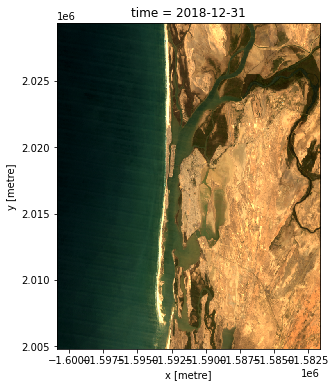

In [9]:
rgb(ds, index=-1)

## Calculate ENDISI (and other indices)

The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a recently developed urbanisation proxy that has been shown to work well in a variety of environments ([Chen et al. 2020](https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1820383)) . Like all normalised difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{ENDISI} = \frac{\text{BLUE} - \text{alpha}*(\text{swir_diff} + \text{MNDWI}^2)}
{\text{BLUE} + \text{alpha}*(\text{swir_diff} + \text{MNDWI}^2)}
\end{aligned}
$$

In [10]:
def MNDWI(dataset):
    return calculate_indices(dataset, index='MNDWI', collection='c1').MNDWI

def Swir_diff(dataset):
    return dataset.swir1/dataset.swir2

def Alpha(dataset):
    return (2*(np.mean(dataset.blue)))/(np.mean(Swir_diff(dataset)) + np.mean(MNDWI(dataset)**2))

def ENDISI(dataset):
    mndwi = MNDWI(dataset)
    swir_diff = Swir_diff(dataset)
    alpha = Alpha(dataset)
    return (dataset.blue - (alpha)*(swir_diff + mndwi**2))/(dataset.blue + (alpha)*(swir_diff + mndwi**2))

In [11]:
# Calculate the ENDISI index
ds['ENDISI'] = ENDISI(ds)

# calculate other indices that might be useful
ds = calculate_indices(ds, index=[ 'NDBI', 'BAEI', 'BUI', 'NBI', 'MNDWI'], collection='c1')

print(ds)

<xarray.Dataset>
Dimensions:  (time: 19, x: 644, y: 819)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-31 2001-12-31 ... 2018-12-31
  * y        (y) float64 2.029e+06 2.029e+06 2.029e+06 ... 2.005e+06 2.005e+06
  * x        (x) float64 -1.601e+06 -1.601e+06 ... -1.582e+06 -1.582e+06
Data variables:
    red      (time, y, x) int16 427 437 439 438 451 ... 2720 2672 2691 2827 2941
    green    (time, y, x) int16 534 527 541 525 539 ... 1873 1851 1835 1869 1889
    blue     (time, y, x) int16 549 541 552 545 565 ... 1179 1154 1144 1143 1138
    nir      (time, y, x) int16 367 351 382 385 384 ... 3945 3910 3921 3961 4072
    swir1    (time, y, x) int16 287 281 286 282 293 ... 5370 5196 5244 5372 5504
    swir2    (time, y, x) int16 235 226 209 216 222 ... 4631 4486 4502 4692 4847
    ENDISI   (time, y, x) float64 -0.5075 -0.5197 -0.5451 ... -0.2143 -0.2149
    NDBI     (time, y, x) float64 -0.1223 -0.1108 -0.1437 ... 0.1512 0.1495
    BAEI     (time, y, x) float64 4.174 4.254 4.15

### Plot ENDISI

Mask out Water

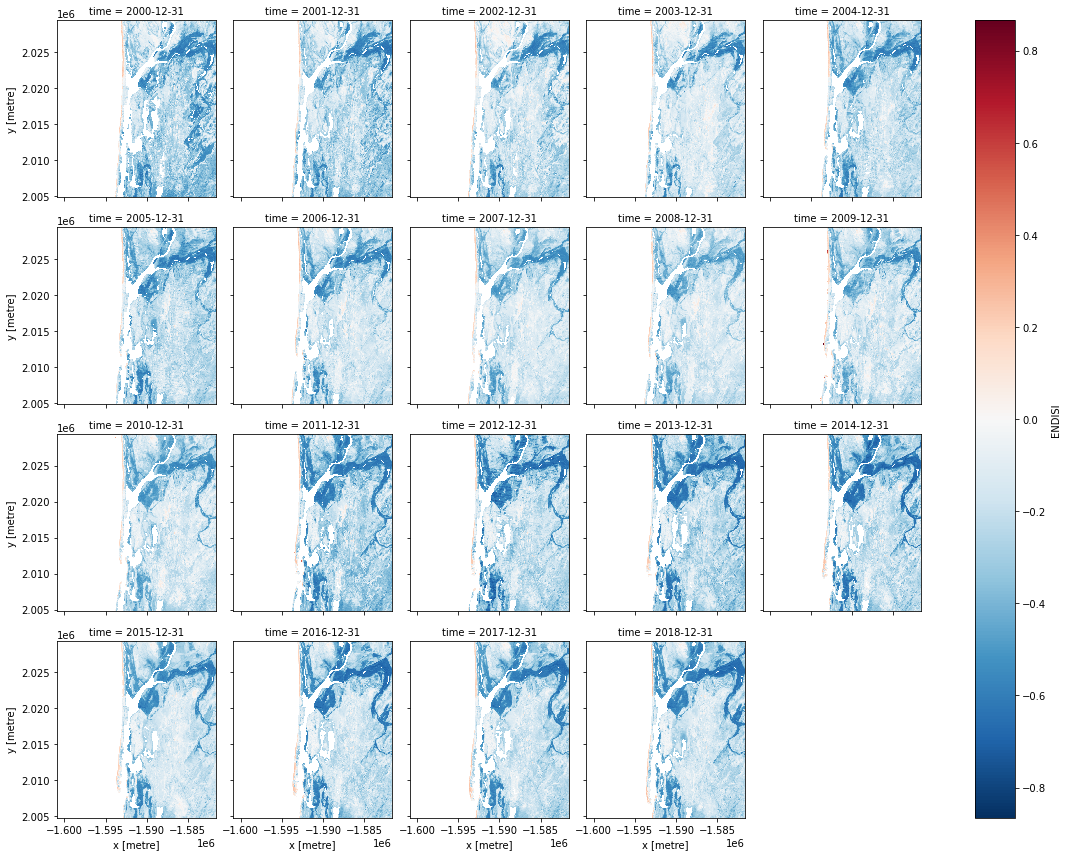

In [12]:
ds.where(ds.MNDWI < 0).isel(time= slice(0,19))['ENDISI'].plot(x="x", y="y", col="time", col_wrap=5);